## [Our DDSP project in github](https://github.com/XinjianOUYANG/Pole_Projet_DDSP)

# Showing the DDSP models we have trained

## Install Dependencies

In [1]:
# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds 
import ddsp
import utils
import os
import gin
import pickle
import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
 
%matplotlib inline
sample_rate = 16000

## Setting the path of audio and model

In [2]:
# audio path
audio_path = 'Datasets/Piano/Audio/Piano_01.wav'

**the model trained with z encoder**

In [3]:
# model folder direction 
model_dir_z = 'Pretrained_Models_for_T2/piano_ae'

# dataset_statistics.pkl in .model folder
dataset_stats_file_z = os.path.join(model_dir_z, 'dataset_statistics.pkl')

# operative_config-0.gin in model folder
gin_file_z = os.path.join(model_dir_z, 'operative_config-0.gin')

the model trained without z encoder

In [4]:
# model folder direction 
model_dir = 'Pretrained_Models_for_T2/sax_solo'

# dataset_statistics.pkl in .model folder
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')

# operative_config-0.gin in model folder
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

## Reading audios and computing (f0,loudness,MFCC)

### Using the given python file [spectral_ops.py](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in ddsp library to compute $f0$ and loudness.
* *ddsp.spectral_ops.compute_f0*

* *ddsp.spectral_ops.compute_loudness*

Datasets/Piano/Audio/Piano_01.wav
shape of original signal: (960000,) 
 original sample rate: 16000
audio shape: (160000,)


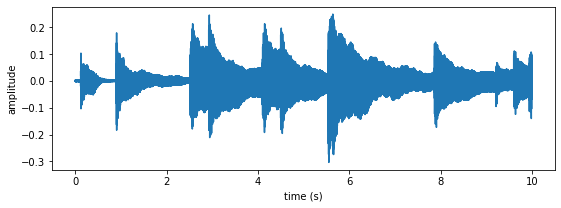

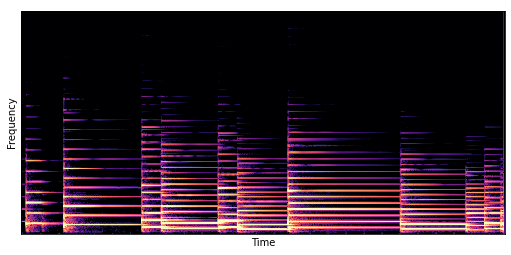

In [5]:
print(audio_path)
x_all, sr = sf.read(audio_path) #data,samplerate
print('shape of original signal:',np.shape(x_all),'\n','original sample rate:',sr)
sig = x_all[:] # choose the first channel of the original audio
 
# resample (down sampling to 16kHz) and take the 10-20 seconds
sig_re = librosa.resample(sig,sr,sample_rate)
audio = sig_re[10*sample_rate:20*sample_rate]
print('audio shape:',np.shape(audio))
audio = audio[np.newaxis,:]

# plot wave form
T_all = audio.shape[1]
time = np.arange(T_all)/sample_rate
plt.figure(figsize=(9,3))
plt.plot(time, audio[0])
plt.xlabel('time (s)')
plt.ylabel('amplitude')

# Calculate Spectrogram and plot
utils.specplot(audio)

In [6]:
# play audio
ipd.Audio(audio[0], rate = sample_rate)

Text(0, 0.5, 'Loudness')

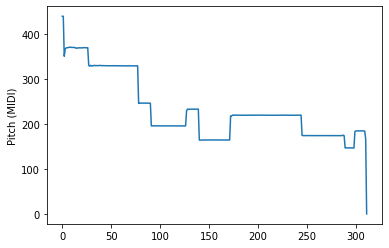

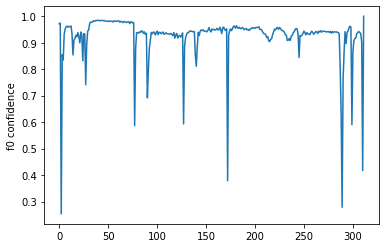

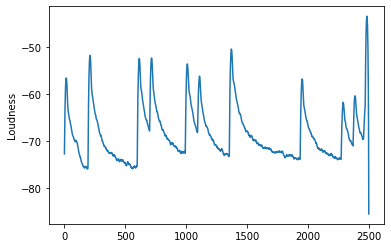

In [7]:
#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio[0], 
                                                       sample_rate= sample_rate,
                                                       frame_rate=31.25,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio[0],
                     sample_rate= sample_rate,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)

# audio_features dictionary
audio_features_key = ['audio','f0_hz','f0_confidence','loundness_db']
audio_features = dict([(k,[]) for k in audio_features_key])
audio_features['audio'] = audio
audio_features['f0_hz'] = f0_crepe
audio_features['f0_confidence'] = f0_confidence
audio_features['loudness_db'] = loudness

# Plot Pitch/f0.
plt.figure(figsize=(6, 4))
f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
plt.plot(np.ravel(f0_crepe), label='crepe')
plt.ylabel('Pitch (MIDI)')
# Plot f0_confidence.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(f0_confidence), label='f0 confidence')
plt.ylabel('f0 confidence')
# Plot Loundness.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(loudness), label='loudness')
plt.ylabel('Loudness')

### Compute z/MFCC

* [DDSP_run](https://github.com/magenta/ddsp/blob/master/ddsp/training/ddsp_run.py)
* training withou z encoder [solo_instrument.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/solo_instrument.gin)
* training with z encoder [ae.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/ae.gin)

**z-encoder**: 

    The encoder ﬁrst calculates MFCC’s (Mel Frequency Cepstrum Coefﬁcients) from the audio. MFCC is computed from the log-mel-spectrogram of the audio with a FFT size of 1024, 128 bins of frequency range between 20Hz to 8000Hz, overlap of 75%. We use only the ﬁrst 30 MFCCs that correspond to a smoothed spectral envelope. The MFCCs are then passed through a normalization layer (which has learnable shift and scale parameters) and a 512-unit GRU. The GRU outputs (over time) fed to a 512-unit linear layer to obtain z(t). The z embedding reported in this model has 16 dimensions across 250 time-steps


<img src=" pictures/Diagram_of_the_z-encoder.jpg " alt="Diagram of the z-encoder" width="800">

* [z encoder](https://github.com/magenta/ddsp/blob/master/ddsp/training/encoders.py) and [MFCC computing file](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in DDSP library
* *ddsp.spectral_ops.compute_mfcc*

Text(0, 0.5, 'MFCC')

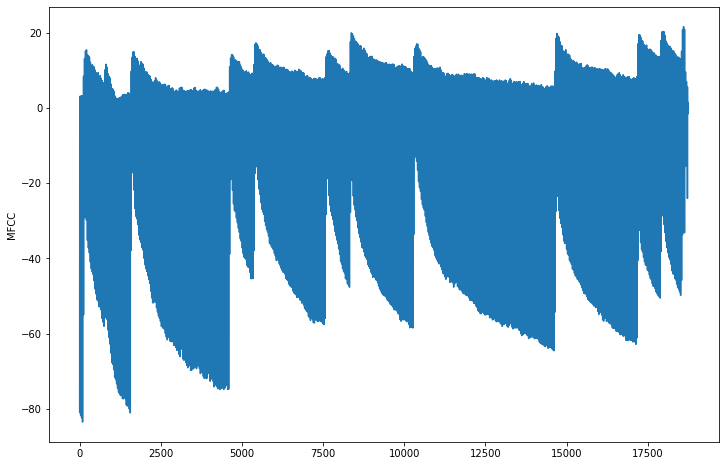

In [8]:
#Calculate MFCC(Mel-frequency Cepstral Coefficients)
mfccs = ddsp.spectral_ops.compute_mfcc(
    audio[0],
    lo_hz=20.0,
    hi_hz=8000.0,
    fft_size=1024,
    mel_bins=128,
    mfcc_bins=30)

# Plot MFCC.
plt.figure(figsize=(12, 8))
plt.plot(np.ravel(mfccs), label='MFCC')
plt.ylabel('MFCC')

### Another way to compute f0 and loudness

In [9]:
# # Setup the session.
# ddsp.spectral_ops.reset_crepe()

# # Compute features.
# audio_features = ddsp.training.metrics.compute_audio_features(audio)
# audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
# audio_features_mod = None

# TRIM = -15
# # Plot Features.
# fig, ax = plt.subplots(nrows=3, 
#                        ncols=1, 
#                        sharex=True,
#                        figsize=(6, 8))
# ax[0].plot(audio_features['loudness_db'][:TRIM])
# ax[0].set_ylabel('loudness_db')

# ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
# ax[1].set_ylabel('f0 [midi]')

# ax[2].plot(audio_features['f0_confidence'][:TRIM])
# ax[2].set_ylabel('f0 confidence')
# _ = ax[2].set_xlabel('Time step [frame]')

## Load the model(without z encoder)

### set paths

In [10]:
print(model_dir,'\n',dataset_stats_file,'\n',gin_file)

Pretrained_Models_for_T2/sax_solo 
 Pretrained_Models_for_T2/sax_solo/dataset_statistics.pkl 
 Pretrained_Models_for_T2/sax_solo/operative_config-0.gin


### load the model

In [11]:
# Load the dataset statistics.
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:n_samples]

# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Resynthesize audio.
outputs = model(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.
# print(outputs.keys())
# dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loundness_db', 
#           'f0_condience', 'loudness_db', 'f0_scaled', 'ld_scaled', 'amps', 
#           'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 
#           'add', 'reverb', 'out', 'audio_synth'])

'''
Another option:
outputs = utils.model_loading(audio,audio_features,model_dir,training=False)
'''
audio_gen = outputs['audio_synth']

Loading dataset statistics from Pretrained_Models_for_T2/sax_solo/dataset_statistics.pkl
Loading dataset statistics from pickle failed: No module named 'google.colab'.


In [12]:
print("original audio")
ipd.Audio(audio, rate = sample_rate)

original audio


In [13]:
print("Resynthesed audio without z encoder")
ipd.Audio(audio_gen, rate = sample_rate)

Resynthesed audio without z encoder


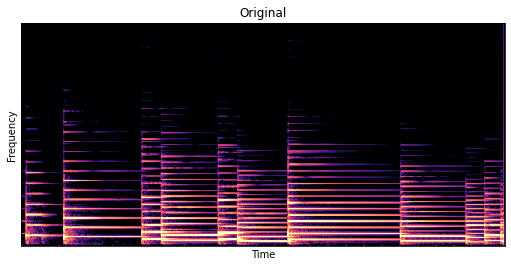

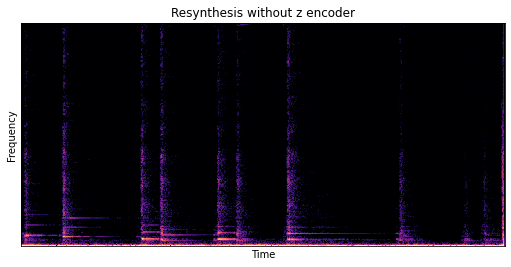

In [14]:
utils.specplot(audio)
plt.title("Original")

utils.specplot(audio_gen)
_ = plt.title("Resynthesis without z encoder")

## load the model(with z)

* [autoencoder.py](https://github.com/magenta/ddsp/blob/master/ddsp/training/models/autoencoder.py)

In [15]:
print(model_dir_z,'\n',dataset_stats_file_z,'\n',gin_file_z)

Pretrained_Models_for_T2/piano_ae 
 Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl 
 Pretrained_Models_for_T2/piano_ae/operative_config-0.gin


In [16]:
# Load the dataset statistics.
print(f'Loading dataset statistics from {dataset_stats_file_z}')
try:
  if tf.io.gfile.exists(dataset_stats_file_z):
    with tf.io.gfile.GFile(dataset_stats_file_z, 'rb') as f:
      DATASET_STATS_Z = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err),'\n')


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file_z, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir_z) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir_z, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:n_samples]

# Set up the model just to predict audio given new conditioning
model_z = ddsp.training.models.Autoencoder()
model_z.restore(ckpt)

# Resynthesize audio.

outputs_z = model_z(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.

# print(outputs.keys())
# dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loundness_db', 
#           'f0_condience', 'loudness_db', 'f0_scaled', 'ld_scaled', 'amps', 
#           'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 
#           'add', 'reverb', 'out', 'audio_synth'])

audio_gen_z = outputs_z['audio_synth']

Loading dataset statistics from Pretrained_Models_for_T2/piano_ae/dataset_statistics.pkl
z latent variable: tf.Tensor([[0.00030354 0.00046772 0.00063468 ... 0.12831481 0.13835935 0.14770402]], shape=(1, 160000), dtype=float32) 
 shape of z (1, 160000)


In [17]:
print('Resynthesis with z encoder')
ipd.Audio(audio_gen_z, rate = sample_rate)

Resynthesis with z encoder


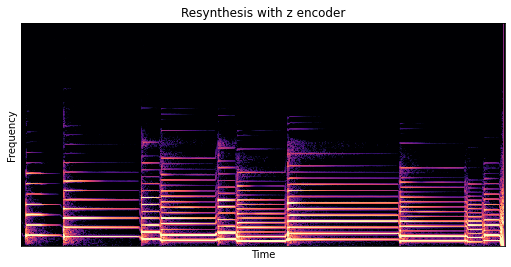

In [18]:
utils.specplot(audio_gen_z)
_ = plt.title("Resynthesis with z encoder")

## Get feature z

In [19]:
z_feature = outputs_z['z']
print(np.shape(z_feature),'\n',z_feature)

(1, 2500, 16) 
 tf.Tensor(
[[[-1.1984451  -0.17736903  0.03165362 ... -0.24654049 -1.1925943
    0.20833051]
  [-1.2622945  -0.23159873  0.01396204 ... -0.20611602 -1.2100301
    0.17720124]
  [-1.3261439  -0.2858284  -0.00372954 ... -0.16569155 -1.2274659
    0.14607197]
  ...
  [-1.027101    0.28272402 -0.05520098 ...  1.0677404  -2.0242884
    1.2165124 ]
  [-1.027101    0.28272402 -0.05520098 ...  1.0677404  -2.0242884
    1.2165124 ]
  [-1.027101    0.28272402 -0.05520098 ...  1.0677404  -2.0242884
    1.2165124 ]]], shape=(1, 2500, 16), dtype=float32)


## Comparing the results

In [20]:
print('Original')
ipd.Audio(audio, rate = sample_rate) 

Original


In [21]:
print('Resynthesis without z encoder')
ipd.Audio(audio_gen, rate = sample_rate)

Resynthesis without z encoder


In [22]:
print('Resynthesis with z encoder')
ipd.Audio(audio_gen_z, rate = sample_rate)

Resynthesis with z encoder


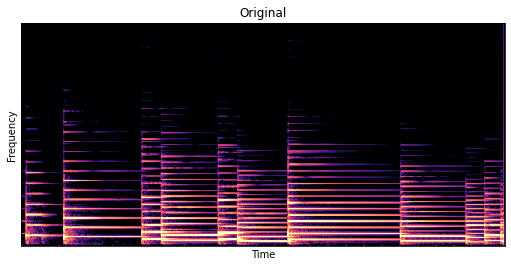

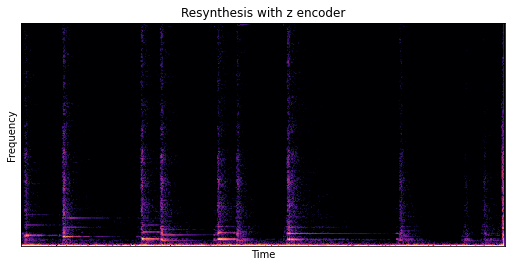

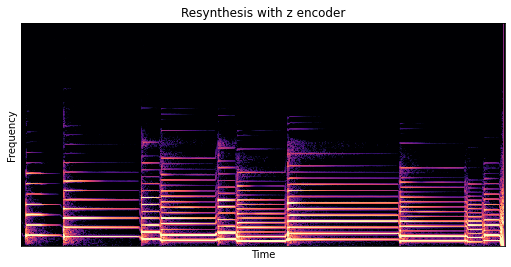

In [23]:
# Plot
utils.specplot(audio)
plt.title("Original")

utils.specplot(audio_gen)
_ = plt.title("Resynthesis without z encoder")

utils.specplot(audio_gen_z)
_ = plt.title("Resynthesis with z encoder")